In [1]:
###########################
#shor algortihm with noise IQFT
###########################

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [5]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

In [6]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return 
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 
    

In [7]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix_0 = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix_0[j][i]=1
             
    for ii in range(N, dim):
        matrix_0[ii][ii] = 1
             
    #matrix = linalg.matrix_power(matrix, 2**power) #possibly dimezzare op. number
    temp = matrix_0
    for iii in range(power):
        matrix = np.dot(temp, temp)
        temp = matrix
        
    U = UnitaryGate(temp)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [8]:
#FUNZIONI PER CIRCUITO NOISY
def qft_rotations(circuit, n, case, position):

    for j in range(n):
        #circuit.barrier(range(n))
        for m in range(j):
            circuit.cp(-np.pi/float(2**(j-m)), m, j)
        #circuit.barrier(range(n))
        
        if case == 4:
            errori(circuit, position)   
        circuit.h(j)
        if case == 5:
            errori(circuit, position)        
        

In [9]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [10]:
def errori(circuit, position):
    
    epsilon = 1                          
    extracted = random.uniform(0, 1)
    if (extracted < epsilon):    
        circuit.x(position)                              #change errors

In [11]:
#INVERSE QFT
def qft(circuit, n, case, position):

    if case == 2:
        errori(circuit, position)

    swap_registers(circuit, n) 
    
    circuit.barrier(range(n))
    if case == 3:
        errori(circuit, position)
        
    if case == 1:
        errori(circuit, position) 

    if case == 0:
        print('hi')
        
    qft_rotations(circuit, n, case, position)
        
    return circuit

In [12]:
#N = int(input("Enter integer N = "))
N = 15

In [13]:
check(N)

y = 8 and N = 15 are coprime - r well defined


In [38]:
y = 2
N = 15

repetition = 150

plot = []
n = math.ceil(math.log(N,2))
#-----CIRCUITO-----

#for case in range(1 , 5):
#    for position in range(2*n):

for rep in range(repetition):
    case = random.randrange(1, 5)
    position = random.randrange(2*n)
    case = 1
    position = 0
    
    control = QuantumRegister(2*n, 'r1')
    target  = QuantumRegister(n, 't1')
    classic = ClassicalRegister(2*n, 'c')
    circuit = QuantumCircuit(control, target, classic)

    circuit.h(range(2*n))
    circuit.x(2*n + n -1)

    for q in range(2*n):
        circuit.append(mod_exp(n, y, N, q),     
                 [q] + [i+2*n for i in range(n)])    

    circuit.save_density_matrix()

    qft(circuit, 2*n, case, position) 
    circuit.measure(range(2*n), range(2*n))
    circuit.draw(fold = -1, scale = 0.5)        

    #-----SIMULAZIONE-------
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(circuit, aer_sim)
    qobj = assemble(t_qc)                             
    results = aer_sim.run(qobj,shots = 1).result()            #1024 shots

    counts = results.get_counts()
    density_matrix = results.data().get('density_matrix')
    labels = []
    for i in range(len(counts)):
        labels.append(   int(list(counts.keys())[i], 2 )   )


    new_counts = dict(zip(labels,list(counts.values()) ))
    #plot_histogram(new_counts)

    #-----DENSITY MATRIX (da cambiare in stato)-----
    density_matrix = np.asarray(density_matrix)
    #for i in range(2**n):
    #    for ii in range(2**n):
    #        print(density_matrix[i][ii])

    #------CALCOLO LE FASI------
    n_count = 2*n
    rows, measured_phases = [], []

    for output in counts:
        decimal = int(output, 2)                       # Convert (base 2) string to decimal
        phase = decimal/(2**n_count)                   # Find corresponding eigenvalue
        measured_phases.append(phase)
                                                       # Add these values to the rows in our table:
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                     f"{decimal}/{2**n_count} = {phase:.2f}"])
                                                       # Print the rows in a table
    headers=["Register Output", "Phase"]
    df = pd.DataFrame(rows, columns=headers)
    #print(df)

    #-----FRAZIONI-----
    rows = []
    period = []

    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(15)
        rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
        period.append(frac.denominator)

    headers=["Phase", "Fraction", "Guess for r"]
    df = pd.DataFrame(rows, columns=headers)
    #print(df)

    #----FATTORIZZAZIONE---
    r = max(period)
    guesses = [gcd(y**(r//2)-1, N), gcd(y**(r//2)+1, N)]
    plot.append(guesses)
    print('case = ', case, 'qubit = ', position, 'fact = ',guesses)
    df = 0
    repetition += 1

(1.6320112457417584e-32+0j)
(-1.8374726433142214e-32+3.1169102265016433e-32j)
(1.3147978407787007e-32-7.7564669507168e-34j)
(-2.779369567764771e-32+3.7386776838675814e-33j)
(1.6320112457417584e-32+0j)
(-1.8374726433142214e-32+3.1169102265016433e-32j)
(1.3147978407787007e-32-7.7564669507168e-34j)
(-2.779369567764771e-32+3.7386776838675814e-33j)
(1.6320112457417584e-32+0j)
(-1.8374726433142214e-32+3.1169102265016433e-32j)
(1.3147978407787007e-32-7.7564669507168e-34j)
(-2.779369567764771e-32+3.7386776838675814e-33j)
(1.6320112457417584e-32+0j)
(-1.8374726433142214e-32+3.1169102265016433e-32j)
(1.3147978407787007e-32-7.7564669507168e-34j)
(-2.779369567764771e-32+3.7386776838675814e-33j)
(-1.8374726433142214e-32-3.1169102265016433e-32j)
(8.02165739308282e-32+0j)
(-1.6284613126631103e-32-2.423747929261631e-32j)
(3.8433116398172027e-32+4.887266342788398e-32j)
(-1.8374726433142214e-32-3.1169102265016433e-32j)
(8.02165739308282e-32+0j)
(-1.6284613126631103e-32-2.423747929261631e-32j)
(3.8433116

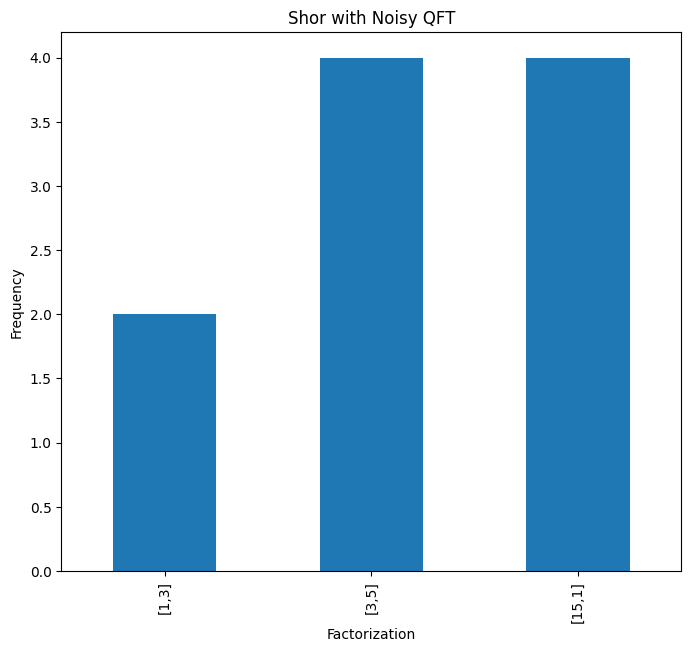

In [27]:
labels = [[1,3], [3,5], [15,1]]
counts = [0, 0, 0]

data = plot


for i in range(len(data)):
    for ii in range(len(labels)):
        if data[i] == labels[ii]:
            counts[ii] += 1
            
frequencies = counts
freq_series = pd.Series(frequencies)
labels = ('[1,3]', '[3,5]', '[15,1]')

plt.figure(figsize=(8, 7))
fig = freq_series.plot(kind='bar')
fig.set_title('Shor with Noisy QFT')
fig.set_xlabel("Factorization")
fig.set_ylabel('Frequency')
fig.set_xticklabels(labels)
plt.savefig('shor_noisy_qft.pdf', format = 'pdf') 
